# Short-Time Fourier Transform (STFT) — Theory and Practice

The **Short-Time Fourier Transform (STFT)** is a tool to analyze **how the frequency content of a signal changes over time**.

It works by:
1. Splitting the signal into short overlapping frames.
2. Applying a **window function** to each frame.
3. Computing the **FFT** of each windowed frame.
4. Arranging results into a time-frequency representation (spectrogram).

**Mathematical definition:**
$$
X_m[k] = \sum_{n=0}^{M-1} x[n + mR] \cdot w[n] \cdot e^{-j 2 \pi kn / N}
$$
- $ m $: frame index
- $ R $: hop size (step between frames)
- $ M $: window length
- $ w[n] $: analysis window
- $ N $: FFT length
- $ k $: frequency bin index

The STFT balances **time resolution** (short windows) and **frequency resolution** (long windows).

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.lib.stride_tricks import as_strided

sns.set_style("whitegrid")

## Creating a test signal

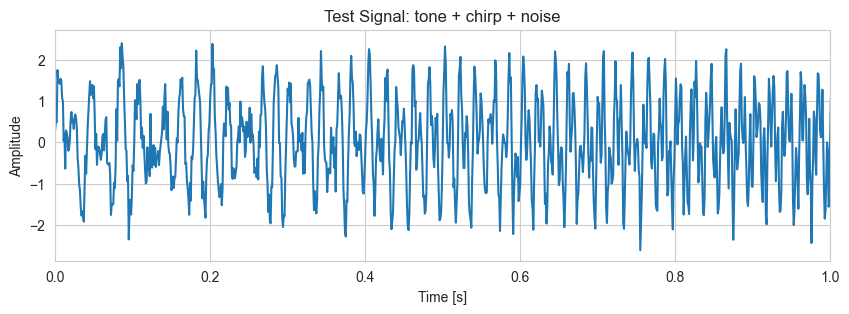

In [2]:
fs = 1000  # Sampling rate (Hz)
T = 2      # Signal duration (seconds)
t = np.linspace(0, T, int(fs*T), endpoint=False)

# Components
tone = np.sin(2*np.pi*50*t)                 # 50 Hz tone
chirp = np.sin(2*np.pi*(20 + 80*t)*t)       # Linear chirp
noise = 0.3*np.random.randn(len(t))         # Gaussian noise

# Combined signal
x = tone + chirp + noise

plt.figure(figsize=(10, 3))
plt.plot(t, x)
plt.title("Test Signal: tone + chirp + noise")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 1)  # zoom into first second
plt.show()


## Naïve STFT implementation

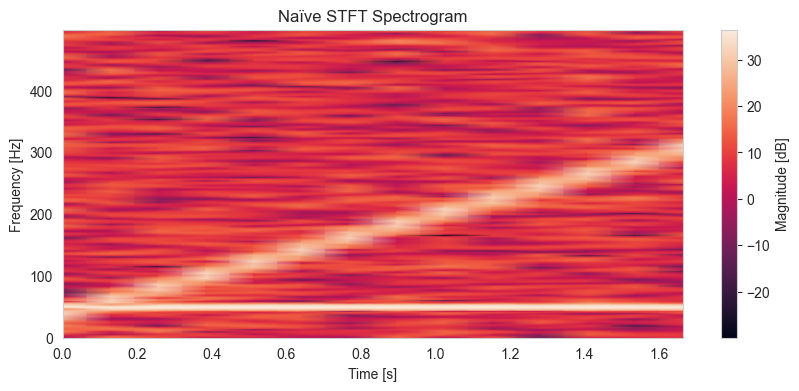

In [3]:
def stft_naive(signal, fs, window_size, hop_size, nfft):
    """Naive STFT implementation using loops."""
    window = np.hanning(window_size)
    n_frames = 1 + (len(signal) - window_size) // hop_size
    stft_matrix = np.zeros((nfft, n_frames), dtype=complex)

    for m in range(n_frames):
        start = m * hop_size
        frame = signal[start:start+window_size] * window
        stft_matrix[:, m] = np.fft.fft(frame, n=nfft)

    freqs = np.fft.fftfreq(nfft, 1/fs)
    times = np.arange(n_frames) * hop_size / fs
    return freqs, times, stft_matrix

# Parameters
M = 256     # window size
R = 128     # hop size
NFFT = 512  # FFT length

freqs, times, X = stft_naive(x, fs, M, R, NFFT)

# Magnitude spectrogram
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, freqs[:NFFT//2], 20*np.log10(np.abs(X[:NFFT//2, :])), shading='gouraud')
plt.title("Naïve STFT Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Magnitude [dB]")
plt.show()


## Stride-Trick Based STFT (Efficient Framing)

Instead of looping through frames, we can create a view into the signal using `np.lib.stride_tricks.as_strided`.
This avoids copying data for each frame, making the STFT faster and more memory-friendly.

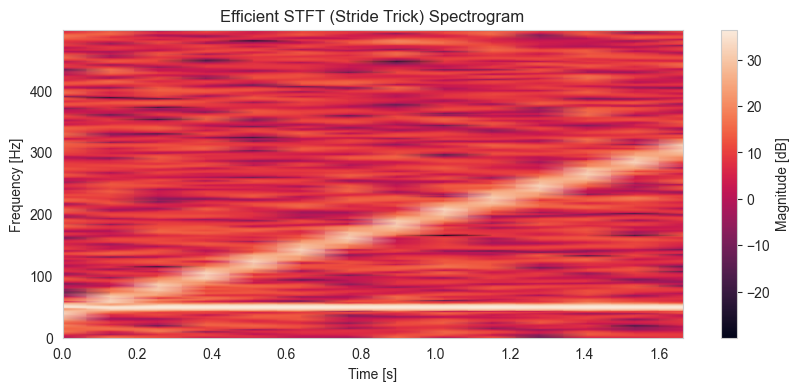

In [5]:
def stft_stride(signal, fs, window_size, hop_size, nfft):
    """Efficient STFT using stride tricks."""
    window = np.hanning(window_size)
    
    # Number of frames
    n_frames = 1 + (len(signal) - window_size) // hop_size
    
    # Stride trick to create 2D framed signal view
    shape = (n_frames, window_size)
    strides = (signal.strides[0]*hop_size, signal.strides[0])
    frames = as_strided(signal, shape=shape, strides=strides)
    
    # Apply window
    windowed_frames = frames * window
    
    # FFT
    stft_matrix = np.fft.fft(windowed_frames, n=nfft, axis=1)
    
    freqs = np.fft.fftfreq(nfft, 1/fs)
    times = np.arange(n_frames) * hop_size / fs
    return freqs, times, stft_matrix

# Parameters
M = 256
R = 128
NFFT = 512

freqs_s, times_s, X_s = stft_stride(x, fs, M, R, NFFT)

# Magnitude spectrogram
plt.figure(figsize=(10, 4))
plt.pcolormesh(times_s, freqs_s[:NFFT//2], 20*np.log10(np.abs(X_s[:, :NFFT//2].T)), shading='gouraud')
plt.title("Efficient STFT (Stride Trick) Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Magnitude [dB]")
plt.show()


## Practical Notes for STFT Implementation

1. **Window choice**:
   - Hanning, Hamming, or Blackman windows are common.
   - Rectangular windows give better time resolution but more spectral leakage.

2. **Overlap**:
   - Higher overlap (e.g., 50% or 75%) improves time resolution but increases computation.

3. **FFT length**:
   - Can be larger than the window size (`nfft > M`) to increase frequency resolution via zero-padding.

4. **Complex-valued inputs**:
   - STFT works directly on complex signals.
   - If the signal is real, `np.isrealobj(signal)` can be used to check; you can cast to complex with:
     ```python
     signal = np.asarray(signal, dtype=complex)
     ```

5. **Stride Trick**:
   - Avoids Python loops by creating a 2D **view** into the signal.
   - This is memory-efficient and faster but requires careful parameter checks to avoid out-of-bounds access.


In [ ]:
# Benchmark naive
start = time.time()
stft_naive(x, fs, M, R, NFFT)
t_naive = time.time() - start

# Benchmark stride
start = time.time()
stft_stride(x, fs, M, R, NFFT)
t_stride = time.time() - start

print(f"Naïve STFT time: {t_naive:.5f} s")
print(f"Stride Trick STFT time: {t_stride:.5f} s")


Naïve STFT time: 0.00200 s
Stride Trick STFT time: 0.00100 s
